# 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
from matplotlib import transforms
import matplotlib.animation as animation
import time as time

sns.set_theme()

# 2. Data Understanding
Trên thực tế việc khám phá dữ liệu đã được nhóm thực hiện một phần ở notebook Data Preprocessing. Ở notebook này, nhóm chủ yếu tìm hiểu sự phân bố của dữ liệu ở các cột
# 2.1. Tổng quan kích thước, kiểu dữ liệu

In [2]:
df = pd.read_csv('data/kill_match_stats_v2.csv')
df.head()

,killed_by,kx,ky,time,vx,vy,dis,phase,type
0,M16A4,4970,3126,1035,4978,3320,194,3.0,AR
1,AKM,4604,4147,1422,4598,4144,7,5.0,AR
2,AKM,4880,3472,1210,4874,3477,8,3.0,AR
3,SKS,5011,4251,1818,4930,4345,124,8.0,DMR
4,M416,4955,4298,1766,4958,4383,85,7.0,AR


In [3]:
df.shape

(8253143, 9)

Dữ liệu có 8,253,143 dòng vaf 9 cột

Mỗi dòng mô tả một kill diễn ra trong trận đấu, gồm:
- `killed_by`: nguyên nhân gây kill
- `kx` và `ky`: tọa của killer trên bản đồ 
- `time`: thời điểm kill xảy ra (tính từ đầu trận đấu)
- `vx` và `vy`: tọa của victim trên bản đồ
- `dis`: khoảng cách giữa killer và victim
- `phase`: phase diễn ra kill
- `type`: phân loại nguyên nhân gây kill

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8253143 entries, 0 to 8253142
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   killed_by  object 
 1   kx         int64  
 2   ky         int64  
 3   time       int64  
 4   vx         int64  
 5   vy         int64  
 6   dis        int64  
 7   phase      float64
 8   type       object 
dtypes: float64(1), int64(6), object(2)
memory usage: 566.7+ MB


Dữ liệu của các cột:
- `killed_by` và `type`: nominal
- `kx`, `ky`, `vx`, `vy`, `dis`: numerical
- `time` và `phase`: 2 cột này mang ý nghĩa thời điểm, nên nhóm xếp 2 cột này vào nhóm dữ liệu `thời gian`

## 2.2. Phân bố của dữ liệu trong từng cột
### 2.2.1. Các cột tọa độ

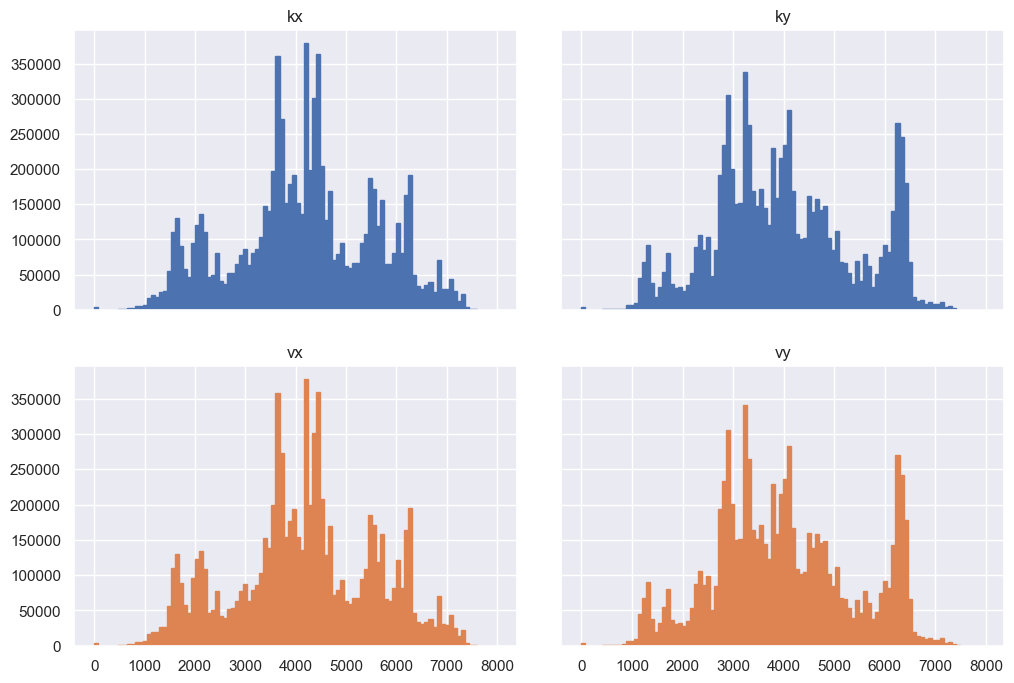

In [5]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(12, 8), sharex = 'col', sharey = 'row')
fig.subplots_adjust(wspace = 0.1)

axes[0][0].hist(df['kx'], bins = 100, edgecolor = 'C0')
axes[0][1].hist(df['ky'], bins = 100, edgecolor = 'C0')
axes[1][0].hist(df['vx'], bins = 100, color = 'C1', edgecolor = 'C1')
axes[1][1].hist(df['vy'], bins = 100, color = 'C1', edgecolor = 'C1')

axes[0][0].set_title('kx')
axes[0][1].set_title('ky')
axes[1][0].set_title('vx')
axes[1][1].set_title('vy');

Cả 4 cột tọa độ đều phân bố trong khoảng từ 0 tới 8000:
- Tọa độ tập trung của killer và victim nhìn chung khá giống nhau
- Đối với các tọa độ x, có khoảng 3 cụm đỉnh lần lượt ở `1500 - hơn 2000`, `3500 - 4500` và `5500 - 6500`
- Đối với các tọa độ y, có một cụm đỉnh lớn trong khoảng `3000 - 4500` và một đỉnh riêng lẻ ở khoảng `6500`
- Vị trí của các cụm sẽ được giải thích ở phần sau, khi nhóm sử dụng nhiều các visualization hơn.

### 2.2.2. Cột dis

<AxesSubplot:xlabel='dis', ylabel='Count'>

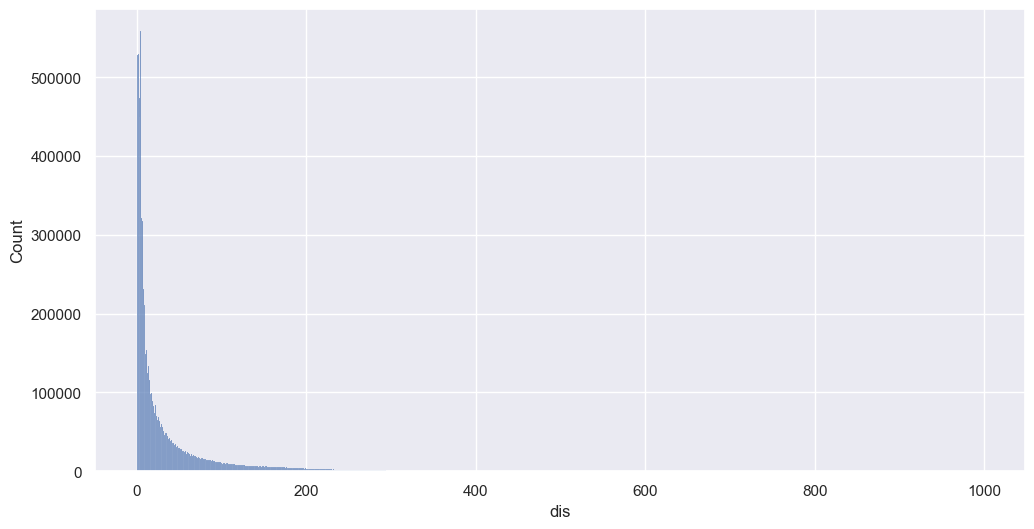

In [6]:
fig = plt.figure(figsize=(12, 6))

sns.histplot(df['dis'], bins = 1000)

Cột `dis` phân bố từ 0 tới 1000 (do nhóm đã thực hiện lọc ở phần Data Preprocessing), tập trung cao nhất ở mức 0, số lượng kill giảm dần khi dis tăng lên (có vẻ là theo hàm log)

### 2.2.3. Cột `time` và `phase`

Text(0.5, 1.0, 'phase')

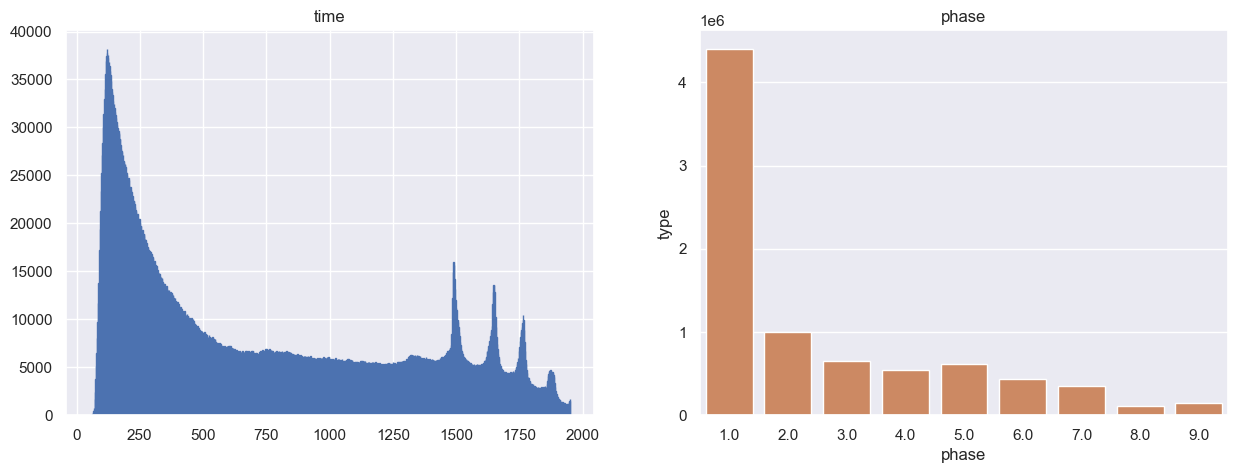

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

axes[0].hist(df['time'], bins = 1000, edgecolor = 'C0')

data = df.groupby(by = ['phase']).count().reset_index()[['phase', 'type']]
sns.barplot(data = data, x = 'phase', y = 'type', ax = axes[1], color = 'C1')

axes[0].set_title('time')
axes[1].set_title('phase')

- Đa số kill diễn ra ở phase 1, giảm dần ở các phase tiếp theo. Có thể do ở phase 1, các player vừa nhảy dù xuống, nhiều player sẽ nhảy dù vào cùng những địa điểm thuận lợi, dẫn tới giao tranh xảy ra vào phase 1 là cao nhất. Sau đó nhiều player tử trận, giao tranh giảm xuống, số lượng kill cũng giảm theo
- Khi quan sát histogram của time, ta nhận thấy có một số đỉnh cao đột ngột từ khoảng 1500s trở về sau, khi xem xét bảng thời gian bắt đầu và kết thúc của các phase dưới đây, ta nhận ra thời điểm kill tăng lên là ở các khoảng thời gian chuyển tiếp từ phase này sang phase kia, khi vòng bluezone thu vào, buộc người chơi phải di chuyển khỏi các nơi trú ẩn. Thêm vào đó là số lượng kill gây ra bởi sát thương từ bluezone, dẫn tới số lượng kill tăng cao. Nhóm kết hợp các đường khoảng đánh dấu phase ở histogram bên dưới để làm nổi bật điều này

|Phase|Bắt đầu|Kết thúc|
|-----|-------|--------|
|1|121|720|
|2|721|1060|
|3|1061|1300|
|4|1301|1480|
|5|1481|1650|
|6|1651|1760|
|7|1761|1880|
|8|1881|1970|
|9|1971|2150|

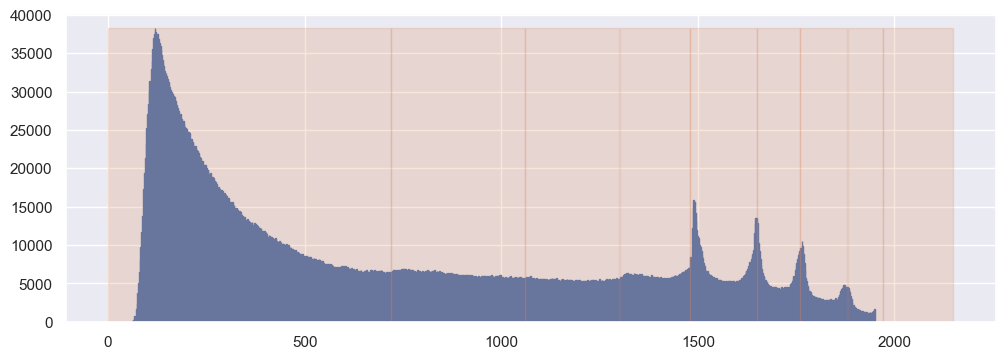

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

y, _, _ = plt.hist(df['time'], bins = 1000, edgecolor = 'C0')

phase_rect = [(0, 720), (721, 1060), (1061, 1300), (1301, 1480), (1481, 1650), (1651, 1760), (1761, 1880), (1881, 1970), (1971, 2150)]

for rect in phase_rect:
    ax.add_patch(patches.Rectangle((rect[0], 0), rect[1] - rect[0], y.max(), color = 'C1', alpha = 0.2))